In [1]:
# COLMAP
%cd /notebooks
!pip install -q plyfile pycolmap Pillow==9.5.0 pycolmap plotly

!sudo apt-get update
!sudo apt-get install libglm-dev

!pip install -q /notebooks/diff-gaussian-rasterization
!pip install -q /notebooks/gaussian-splatting/submodules/simple-knn

!apt install imagemagick -y
# remove line 88 of vim ~/../etc/ImageMagick-6/policy.xml to run MoviePy
!sed -i '88d' ~/../etc/ImageMagick-6/policy.xml 

!sudo apt-get update && sudo apt-get install -y \
	ninja-build \
	libeigen3-dev \
	libflann-dev \
	libsqlite3-dev \
	libgl1-mesa-dev \
	cmake \
	libgoogle-glog-dev \
	libgflags-dev \
	libsuitesparse-dev \
	libceres-dev \
	libcgal-dev \
	libcgal-qt5-dev \
	libmetis-dev \
	libfreeimage-dev \
	libglew-dev

!sudo updatedb   # update the database used by locate
!locate Eigen3Config.cmake
!locate libflann

# # # Build COLMAP
# !git clone https://github.com/colmap/colmap.git
# %cd /notebooks/colmap
# !rm -rf build
# !mkdir build
# %cd /notebooks/colmap/build
# !cmake .. -DCMAKE_CUDA_ARCHITECTURES=native -GNinja

%cd /notebooks/colmap/build
!ninja
!sudo ninja install

# Check if colmap is installed
!colmap -h

%cd /notebooks


#HLOC
!pip install mediapy

# !rm -rf /notebooks/Hierarchical-Localization
# !git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/

%cd /notebooks/Hierarchical-Localization
!pip install --progress-bar off --quiet -e .


%cd /notebooks

Installing Python libraries...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 94.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 90.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0

Installing system packages for COLMAP...

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 https://deb.nodesource.com/node_16.x focal InRelease [4583 B]            
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1188 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]  

In [11]:
# Change to the appropriate directory
%cd /notebooks/Hierarchical-Localization

# Import libraries from hloc
from hloc import (
	extract_features, 
	match_features, 
	reconstruction, 
	visualization, 
	pairs_from_retrieval, 
	colmap_from_nvm, 
	pairs_from_exhaustive, 
	pairs_from_covisibility
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Update system path
import sys
third_party_path = '/notebooks/Hierarchical-Localization/third_party'
sys.path.extend([
	third_party_path, 
	f'{third_party_path}/d2net',
	f'{third_party_path}/deep-image-retrieval',
	f'{third_party_path}/r2d2',
	f'{third_party_path}/SuperGluePretrainedNetwork'
])

# Navigate back to the notebooks directory
%cd /notebooks

# Import standard libraries
import os
import io
import glob
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta
from PIL import Image, ImageFilter, ImageChops

# Import additional libraries
import mediapy as media
import torch
import pycolmap
import sqlite3

/notebooks/Hierarchical-Localization
/notebooks


In [12]:
# Connect to the database
%cd /notebooks
connection = sqlite3.connect('sample_db.sqlite')

# Define the search parameters
tl_lat = 160.7128
tl_long = -74.0060
br_lat = 10.6977
br_long = -13.9792

cursor = connection.cursor()
cursor.execute("SELECT image_blob FROM maptodon_raw WHERE lat BETWEEN ? AND ? AND long BETWEEN ? AND ?", (br_lat, tl_lat, tl_long, br_long))
results = cursor.fetchall()

# Delete working image, and create a new one
!rm -rf working
!mkdir working
!mkdir working/input

# Process the search results
image_hashes = {}
if len(results) > 0:
	for i, row in enumerate(results):
		image_data = row[0]

		# Save to working directory
		image = Image.open(io.BytesIO(image_data))

		image.save("./working/input/image_{:05d}.png".format(i))
	print("Saved " + str(len(results)) + " images to working directory.")
else:
	print("No results found.")

# Close the database connection
connection.close()

/notebooks
Saved 40 images to working directory.


In [13]:
%%time
%cd /notebooks

location = Path('./working')
images = location / 'input'
image_list = [path.split(str(images.stem) + "/")[-1] for path in sorted(glob.glob(str(images / '*')))]
outputs = location / 'sfm'
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_max']
matcher_conf = match_features.confs['superglue']

extract_features.main(feature_conf, images, image_list=image_list, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=image_list)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=image_list)

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

[2023/10/14 23:52:04 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


/notebooks
Loaded SuperPoint model


100%|██████████| 40/40 [00:02<00:00, 17.97it/s]
[2023/10/14 23:52:06 hloc INFO] Finished exporting features.
[2023/10/14 23:52:06 hloc INFO] Found 780 pairs.
[2023/10/14 23:52:06 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


ValueError: too many values to unpack (expected 2)

In [ ]:
%%time
print("\nRunning COLMAP image undistorter...\n")

# Running COLMAP image undistorter
undistorted_path = f"{work_dir}/undistorted"

!colmap image_undistorter \
	--image_path /notebooks/working/input \
	--input_path {sfm_dir} \
	--output_path {undistorted_path} \
	--output_type COLMAP \
	# --max_image_size 2000

# # Doesn't work
# pycolmap.undistort_images(sfm_dir, "/notebooks/walk/input", "/notebooks/walk_output", output_type="COLMAP")

!mv /notebooks/working/sparse/ /notebooks/working/sparse_tmp/
!mkdir /notebooks/working/sparse/
!mv /notebooks/working/sparse_tmp/ /notebooks/working/sparse/0/

In [ ]:
!python /content/gaussian-splatting/train.py -s {undistorted_path} -r 2


/notebooks
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-li

,,,
,,,
,,,
,,,

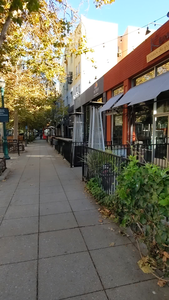
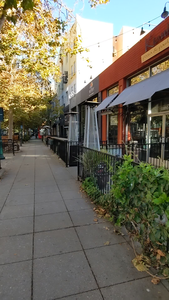
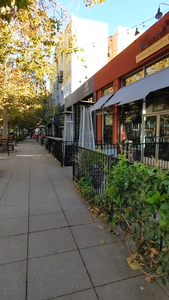
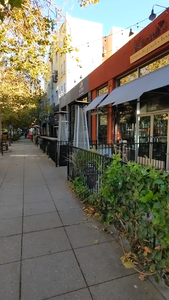
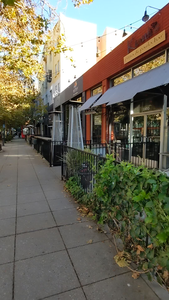
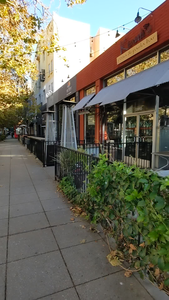
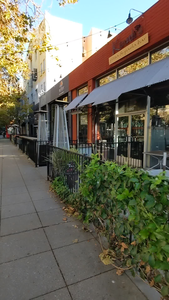
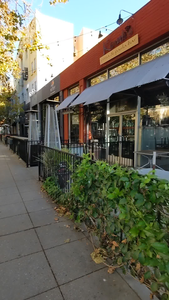
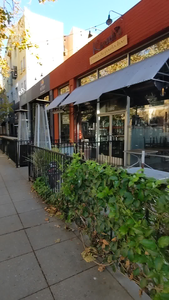
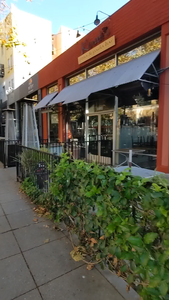
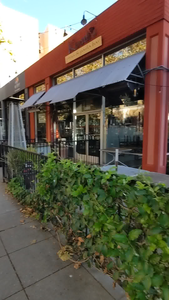
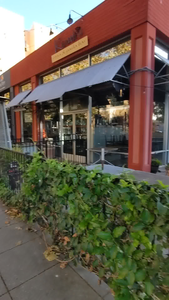
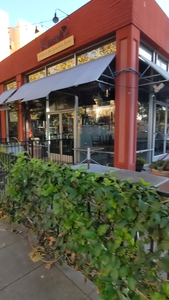
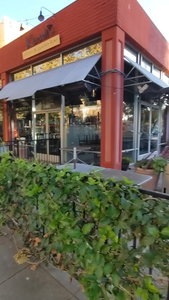
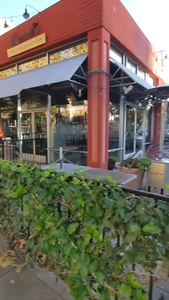
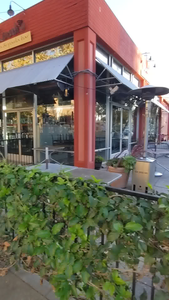

CPU times: user 916 ms, sys: 268 ms, total: 1.18 s
Wall time: 7.99 s


In [26]:
%%time
%cd /notebooks

# Prepare the input images
!rm -rf /notebooks/walk
!mkdir /notebooks/walk
!mkdir /notebooks/walk/input

init_videos = glob.glob("/notebooks/data/*.mp4")
init_videos.sort()
init_video = init_videos[1]

# !ffmpeg -i {init_video} -ss 00:00:00 -t 00:00:02 -vf fps=5 /notebooks/walk/input/%05d.png
!ffmpeg -i {init_video} -vf fps=10 /notebooks/walk/input/%05d.jpeg

print("\n\n")
print("Number of images:", len(glob.glob("/notebooks/walk/input/*.jpeg")))

images = sorted(glob.glob('/notebooks/walk/input/*.jpeg'))
print(len(images))

show_images = [cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB) for im in images[:16]]
media.show_images(show_images, height=300, columns=4)

In [27]:
!zip -r /notebooks/walk/input.zip /notebooks/walk/input

  adding: notebooks/walk/input/ (stored 0%)
  adding: notebooks/walk/input/00015.jpeg (deflated 1%)
  adding: notebooks/walk/input/00004.jpeg (deflated 0%)
  adding: notebooks/walk/input/00068.jpeg (deflated 3%)
  adding: notebooks/walk/input/00003.jpeg (deflated 0%)
  adding: notebooks/walk/input/00012.jpeg (deflated 1%)
  adding: notebooks/walk/input/00036.jpeg (deflated 3%)
  adding: notebooks/walk/input/00052.jpeg (deflated 3%)
  adding: notebooks/walk/input/00099.jpeg (deflated 1%)
  adding: notebooks/walk/input/00074.jpeg (deflated 2%)
  adding: notebooks/walk/input/00014.jpeg (deflated 1%)
  adding: notebooks/walk/input/00106.jpeg (deflated 1%)
  adding: notebooks/walk/input/00011.jpeg (deflated 1%)
  adding: notebooks/walk/input/00048.jpeg (deflated 3%)
  adding: notebooks/walk/input/00035.jpeg (deflated 3%)
  adding: notebooks/walk/input/00001.jpeg (deflated 1%)
  adding: notebooks/walk/input/00063.jpeg (deflated 3%)
  adding: notebooks/walk/input/00090.jpeg (deflated 1%)
  ad